In [1]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
rcParams = {'font.size': 24 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)
Plots_Dir = '../../Plots/Iterative_Clustering/'

def Filter(grp, cutoff):
    return len(grp[grp['Size'] >= cutoff])

def Get_Cluster_Summary(sampledir, cluster_cutoff, filter_string = 'alpha_'):
    sampling_rates = listdir(sampledir)
    op = []
    df_grp = pd.DataFrame()
    for s in sampling_rates:
        if s.startswith("."):
            continue
        sample_rate = float(s.replace(filter_string,""))
        df = pd.read_csv(sampledir+s+'/Cluster_Summary.txt', sep = "\t")
        temp = pd.DataFrame()
        temp['Cluster_Counts'] = df.groupby('Iteration').apply(partial(Filter, cutoff = cluster_cutoff))
        temp = temp.sort_values(by = 'Iteration')
        print(sample_rate, temp['Cluster_Counts'].sum())
        temp['Cluster_Counts'] = temp['Cluster_Counts'].cumsum()
        temp['Sample_Rate'] = sample_rate
        temp = temp.reset_index()
        df_grp = df_grp.append(temp)
    df_grp = df_grp.set_index(['Sample_Rate', 'Iteration'])
    return df_grp

def Load_Cluster_Summaries(sampledir, cutoff, ms = True, adaptive = True, filter_string = 'alpha_'):
    sampling_rates = listdir(sampledir)
    op = []
    for s in sampling_rates:
        print(s)
        if s.startswith("."):
            continue
        sample_rate = s.replace(filter_string,"")
        iter_dir = listdir(sampledir+s+'/')
        for i in iter_dir: 
            try:
                d = {}
                if i.startswith('Iteration'):
                    iter_id = i.replace("Iteration_","")
                    summary = open(sampledir+'/'+s+'/'+i+'/summary_'+iter_id+'.txt').readlines()[1:]
                    #print(sampledir+'/'+s+'/'+i+'/summary_'+iter_id+'.txt')
                    for t in summary:
                        if t != "\n":
                            t = t.split(": ")
                            d[t[0]] = float(t[1].replace("\n",""))
                    benchmark = open(sampledir+'/'+s+'/'+i+'/benchmark_'+iter_id+'.txt').readlines()
                    for b in benchmark:
                        b = b.replace(" minutes ","").split(": ")
                        d[b[0]] = float(b[1])
                    d['Iteration'] = int(iter_id)
                    d['Sample_Freq'] = float(sample_rate)
                    op.append(d)
            except FileNotFoundError:
                continue
    df = pd.DataFrame(op)
    df = df.set_index(['Sample_Freq', 'Iteration'])
    df = df.sort_index().reset_index()
    df = df.rename(columns = {'Sampling Rate':'Sampling_Rate', 'Sampling rate':'Sampling_Rate'})
    if(ms):
        col = 'Clustered sequences(After shifting the center)'
    else:
        col = 'Clustered sequences(Baiting on dnaclust centers)'
    df_op = df[[col,'Full iteration','Iteration','Sample_Freq']]
    df_op = df_op.sort_values(by = ['Sample_Freq','Iteration'])
    df_grp = df_op.groupby('Sample_Freq')
    df_op['Cumulative_Clustered'] = df_grp[col].transform(pd.Series.cumsum)
    df_op['Cumulative_Time'] = df_grp['Full iteration'].transform(pd.Series.cumsum)
    if(adaptive):
        df_op = pd.merge(df_op, df[['Sample_Freq','Iteration','Sampling_Rate']], 
                         left_on = ['Sample_Freq','Iteration'], right_on = ['Sample_Freq','Iteration'])
    df_op = df_op.rename(columns={'Sample_Freq':'Sample_Rate'})
    df_op.set_index(['Sample_Rate', 'Iteration'], inplace = True)
    df_cluster_counts = Get_Cluster_Summary(sampledir, cutoff, filter_string)
    df_op = df_op.join(df_cluster_counts)
    df_op = df_op.reset_index()
    df_op.set_index('Sample_Rate', inplace = True)
    return df, df_op



In [2]:
expt_dir = '/Users/harihara/Mount/Iterative_Clustering/Experiments/'
df_ms_adaptive, df_ms_adaptive_summary = Load_Cluster_Summaries(expt_dir+'With_Modeshifting/Adaptive/', 20)
df_ms_fixalpha, df_ms_fixalpha_summary = Load_Cluster_Summaries(expt_dir+'With_Modeshifting/Fix_Alpha/',20,
                                                               adaptive = False)
df_no_ms_adaptive, df_no_ms_adaptive_summary = Load_Cluster_Summaries(expt_dir+'No_Modeshifting/Adaptive/',20, 
                                                                      ms = False)
df_no_ms_fixalpha, df_no_ms_fixalpha_summary = Load_Cluster_Summaries(expt_dir+'No_Modeshifting/Fix_Alpha/',20,
                                                                      ms = False, adaptive = False)

._.DS_Store
.DS_Store
alpha_5.0
alpha_10.0
alpha_0.5
alpha_1.0
alpha_0.1
5.0 4889
10.0 5281
0.5 4620
1.0 4439
0.1 4826
._.DS_Store
.DS_Store
alpha_5.0
alpha_10.0
alpha_0.5
alpha_1.0
alpha_0.1
5.0 4988
10.0 5339
0.5 3827
1.0 4382
0.1 2085
._.DS_Store
.DS_Store
alpha_5.0
alpha_10.0
alpha_0.5
alpha_1.0
alpha_0.1
5.0 10579
10.0 10964
0.5 10050
1.0 10019
0.1 9923
._.DS_Store
.DS_Store
alpha_5.0
alpha_10.0
alpha_0.5
alpha_1.0
alpha_0.1
5.0 10440
10.0 11153
0.5 8196
1.0 9603
0.1 3836


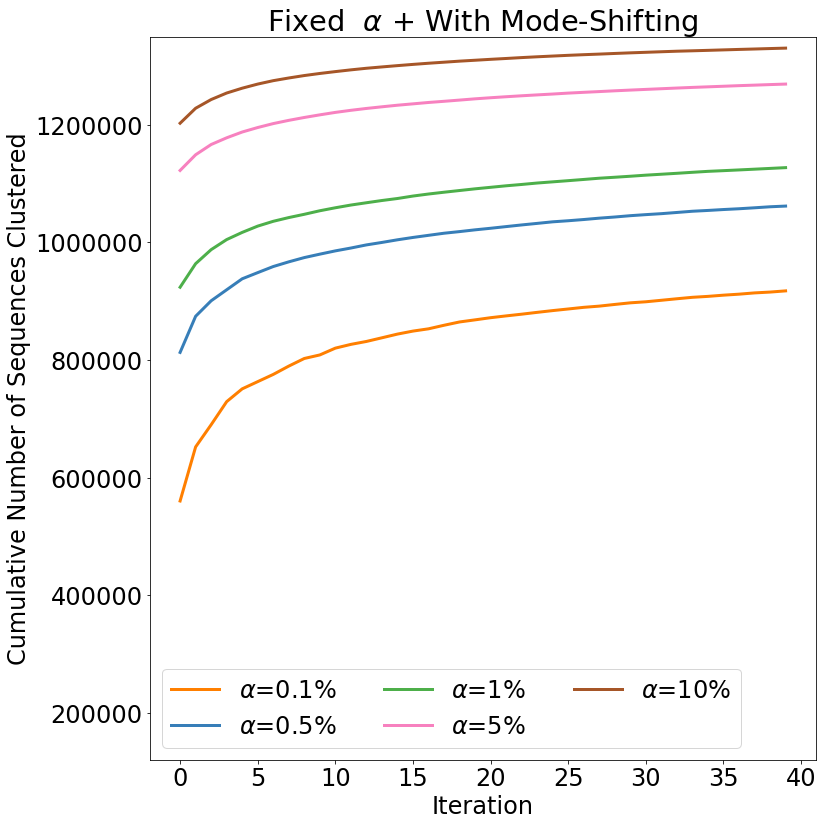

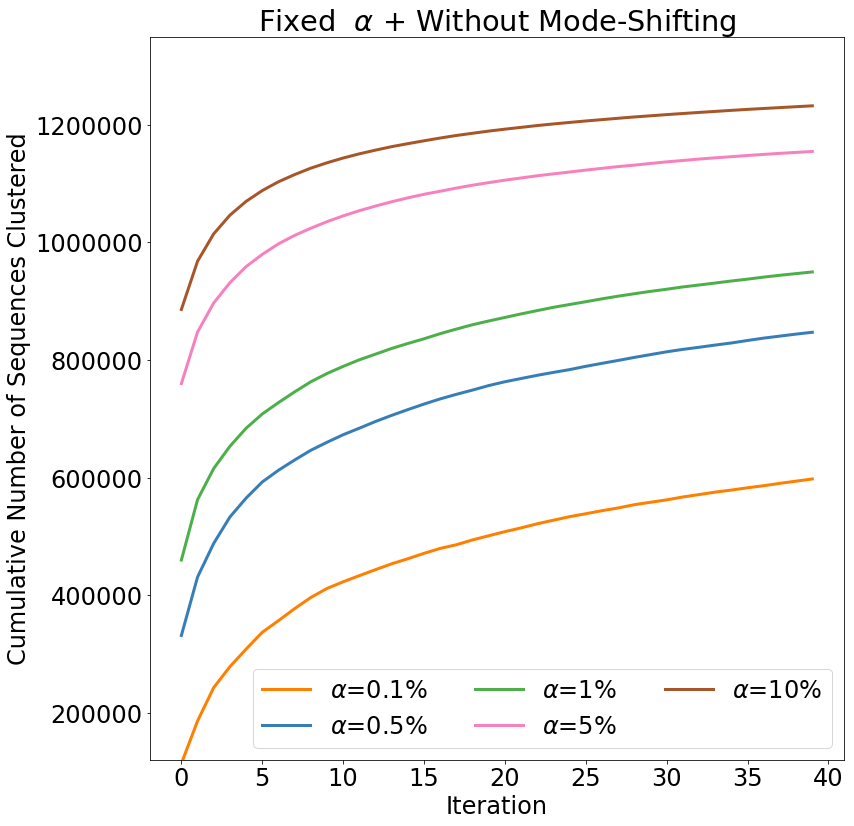

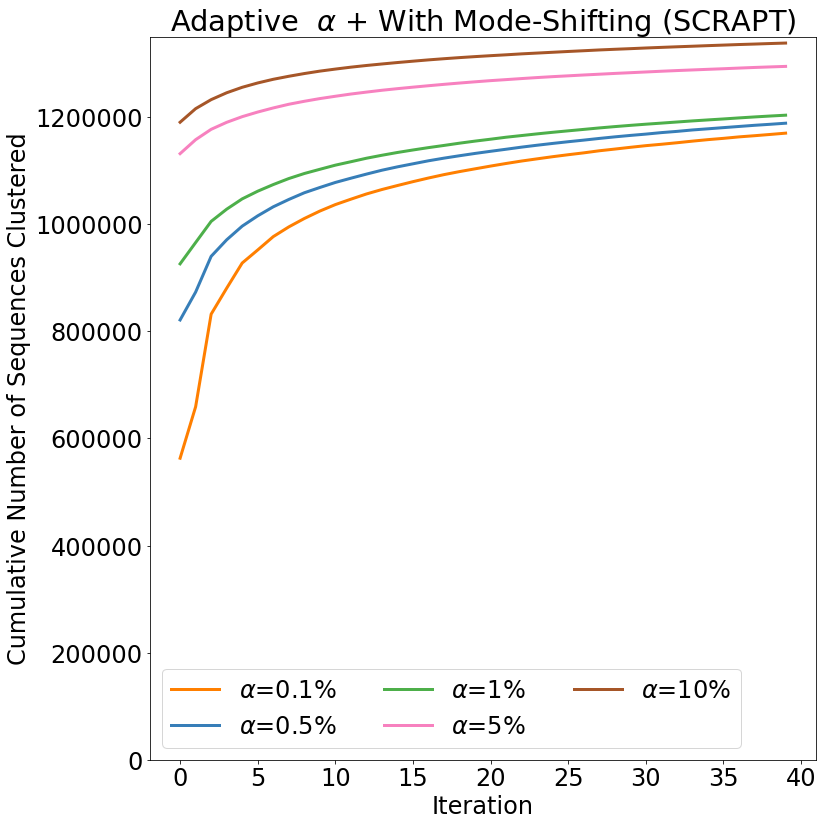

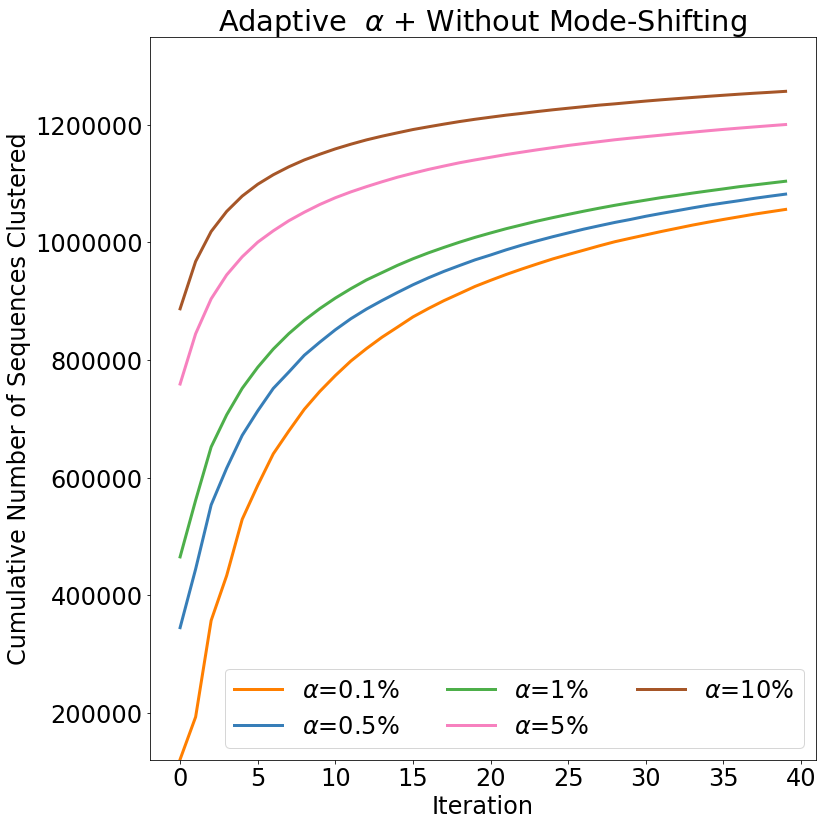

In [11]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,1,figsize = (12,12))
colors = ['#ff7f00','#377eb8','#4daf4a','#f781bf', '#a65628']

df_ms_fixalpha_summary.loc[0.1].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'0.1%', 
                                     color = colors[0], linewidth = 3)
df_ms_fixalpha_summary.loc[0.5].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'0.5%', 
                                     color = colors[1], linewidth = 3)
df_ms_fixalpha_summary.loc[1].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'1%', 
                                   color = colors[2], linewidth = 3)
df_ms_fixalpha_summary.loc[5].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'5%', 
                                   color = colors[3], linewidth = 3)
df_ms_fixalpha_summary.loc[10].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'10%', 
                                    color = colors[4], linewidth = 3)
ax.set_title(r'Fixed  $\alpha$ + With Mode-Shifting')
ax.legend(ncol = 3)
ax.set_ylabel('Cumulative Number of Sequences Clustered')
fig.tight_layout()
ax.set_ylim([120000, 1350000])
fig.savefig(Plots_Dir+'Fixed_Alpha_MS.pdf')

fig, ax = plt.subplots(1,1,figsize = (12,12))
df_no_ms_fixalpha_summary.loc[0.1].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'0.1%', 
                                     color = colors[0], linewidth = 3)
df_no_ms_fixalpha_summary.loc[0.5].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'0.5%', 
                                     color = colors[1], linewidth = 3)
df_no_ms_fixalpha_summary.loc[1].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'1%', 
                                   color = colors[2], linewidth = 3)
df_no_ms_fixalpha_summary.loc[5].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'5%', 
                                   color = colors[3], linewidth = 3)
df_no_ms_fixalpha_summary.loc[10].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'10%', 
                                    color = colors[4], linewidth = 3)
ax.set_title(r'Fixed  $\alpha$ + Without Mode-Shifting')
ax.legend(ncol = 3)
fig.tight_layout()
ax.set_ylabel('Cumulative Number of Sequences Clustered')
ax.set_ylim([120000, 1350000])
fig.savefig(Plots_Dir+'Fixed_Alpha_WO_MS.pdf')

fig, ax = plt.subplots(1,1,figsize = (12,12))
df_ms_adaptive_summary.loc[0.1].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'0.1%', 
                                     color = colors[0], linewidth = 3)
df_ms_adaptive_summary.loc[0.5].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'0.5%', 
                                     color = colors[1], linewidth = 3)
df_ms_adaptive_summary.loc[1].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'1%', 
                                   color = colors[2], linewidth = 3)
df_ms_adaptive_summary.loc[5].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'5%', 
                                   color = colors[3], linewidth = 3)
df_ms_adaptive_summary.loc[10].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'10%', 
                                    color = colors[4], linewidth = 3)
ax.set_title(r'Adaptive  $\alpha$ + With Mode-Shifting (SCRAPT)')
ax.set_ylabel('Cumulative Number of Sequences Clustered')
fig.tight_layout()
ax.legend(ncol = 3)
ax.set_ylim([0, 1350000])
fig.savefig(Plots_Dir+'Adaptive_Alpha_MS.pdf')

fig, ax = plt.subplots(1,1,figsize = (12,12))
df_no_ms_adaptive_summary.loc[0.1].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'0.1%', 
                                     color = colors[0], linewidth = 3)
df_no_ms_adaptive_summary.loc[0.5].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'0.5%', 
                                     color = colors[1], linewidth = 3)
df_no_ms_adaptive_summary.loc[1].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'1%', 
                                   color = colors[2], linewidth = 3)
df_no_ms_adaptive_summary.loc[5].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'5%', 
                                   color = colors[3], linewidth = 3)
df_no_ms_adaptive_summary.loc[10].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\alpha$='+'10%', 
                                    color = colors[4], linewidth = 3)
ax.set_title(r'Adaptive  $\alpha$ + Without Mode-Shifting')
ax.set_ylabel('Cumulative Number of Sequences Clustered')
fig.tight_layout()
ax.legend(ncol = 3)
ax.set_ylim([120000, 1350000])
fig.savefig(Plots_Dir+'Adaptive_Alpha_WO_MS.pdf')

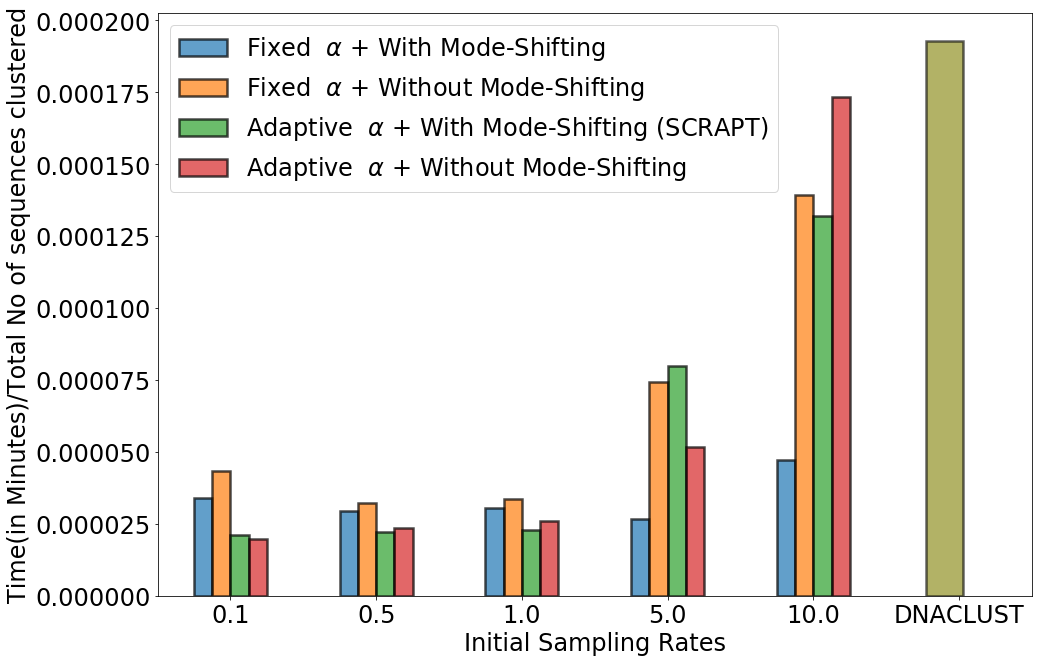

In [4]:
df_ms_fixalpha_time = df_ms_fixalpha_summary.loc[df_ms_fixalpha_summary['Iteration'] == 39,
                                                 ['Cumulative_Time','Cumulative_Clustered']]
df_ms_fixalpha_time['Cumulative_Time'] = df_ms_fixalpha_time['Cumulative_Time']/df_ms_fixalpha_time['Cumulative_Clustered']
df_ms_fixalpha_time = df_ms_fixalpha_time.rename(columns = {'Cumulative_Time':r'Fixed  $\alpha$ + With Mode-Shifting'})
del df_ms_fixalpha_time['Cumulative_Clustered']

df_no_ms_fixalpha_time = df_no_ms_fixalpha_summary.loc[df_no_ms_fixalpha_summary['Iteration'] == 39,
                                                       ['Cumulative_Time', 'Cumulative_Clustered']]
df_no_ms_fixalpha_time['Cumulative_Time'] = df_no_ms_fixalpha_time['Cumulative_Time']/df_no_ms_fixalpha_time['Cumulative_Clustered']
del df_no_ms_fixalpha_time['Cumulative_Clustered']

df_no_ms_fixalpha_time = df_no_ms_fixalpha_time.rename(columns = {'Cumulative_Time':r'Fixed  $\alpha$ + Without Mode-Shifting'})
df_time = df_ms_fixalpha_time.join(df_no_ms_fixalpha_time)

df_ms_adaptive_time = df_ms_adaptive_summary.loc[df_ms_adaptive_summary['Iteration'] == 39,
                                                 ['Cumulative_Time', 'Cumulative_Clustered']]
df_ms_adaptive_time['Cumulative_Time'] = df_ms_adaptive_time['Cumulative_Time']/df_ms_adaptive_time['Cumulative_Clustered']
del df_ms_adaptive_time['Cumulative_Clustered']

df_no_ms_adaptive_time = df_no_ms_adaptive_summary.loc[df_no_ms_adaptive_summary['Iteration'] == 39,
                                                       ['Cumulative_Time','Cumulative_Clustered']]
df_no_ms_adaptive_time['Cumulative_Time'] = df_no_ms_adaptive_time['Cumulative_Time']/df_no_ms_adaptive_time['Cumulative_Clustered']

df_ms_adaptive_time = df_ms_adaptive_time.rename(columns = {'Cumulative_Time':r'Adaptive  $\alpha$ + With Mode-Shifting (SCRAPT)'})
df_no_ms_adaptive_time = df_no_ms_adaptive_time.rename(columns = {'Cumulative_Time':r'Adaptive  $\alpha$ + Without Mode-Shifting'})
del df_no_ms_adaptive_time['Cumulative_Clustered']

df_time = df_time.join(df_ms_adaptive_time)
df_time = df_time.join(df_no_ms_adaptive_time)

fig, ax = plt.subplots(1,1,figsize = (15,10))
df_time.plot(kind = 'bar', ax = ax, alpha = 0.7, edgecolor = 'black', linewidth = 2.5)
ax.bar(x = [4.9], height = [260/1347906], label = 'DNACLUST', color = 'olive', edgecolor = 'black', linewidth = 2.5,
       width = 0.25, alpha = 0.6)

ax.set_xlabel('Start Sampling Rates')
ax.set_ylabel('Time(in Minutes)/Total No of sequences clustered')
ax.set_xlim([-0.5, 5.5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['0.1','0.5','1.0','5.0','10.0','DNACLUST'], rotation = 0)
ax.set_xlabel('Initial Sampling Rates')
#ax.set_yscale('log')
fig.tight_layout()

fig.savefig(Plots_Dir+'Time_Benchmarks_Normalized.pdf')

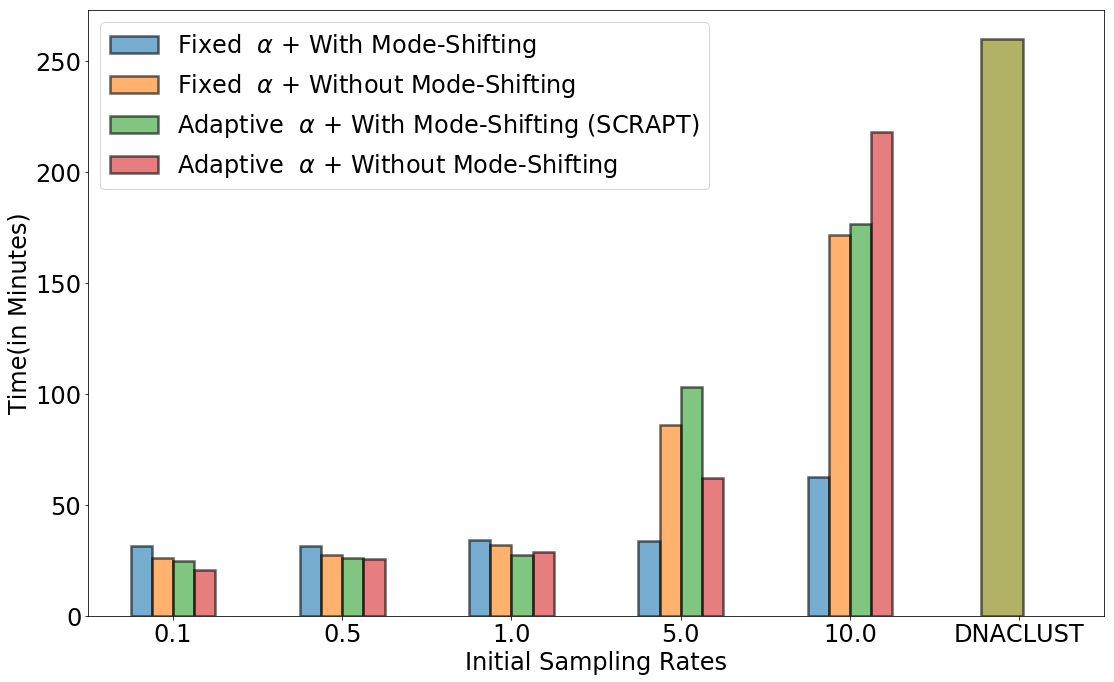

In [5]:
df_ms_fixalpha_time = df_ms_fixalpha_summary.loc[df_ms_fixalpha_summary['Iteration'] == 39,
                                                 ['Cumulative_Time','Cumulative_Clustered']]
df_ms_fixalpha_time['Cumulative_Time'] = df_ms_fixalpha_time['Cumulative_Time']#/df_ms_fixalpha_time['Cumulative_Clustered']
df_ms_fixalpha_time = df_ms_fixalpha_time.rename(columns = {'Cumulative_Time':r'Fixed  $\alpha$ + With Mode-Shifting'})
del df_ms_fixalpha_time['Cumulative_Clustered']

df_no_ms_fixalpha_time = df_no_ms_fixalpha_summary.loc[df_no_ms_fixalpha_summary['Iteration'] == 39,
                                                       ['Cumulative_Time', 'Cumulative_Clustered']]
df_no_ms_fixalpha_time['Cumulative_Time'] = df_no_ms_fixalpha_time['Cumulative_Time']#/df_no_ms_fixalpha_time['Cumulative_Clustered']
del df_no_ms_fixalpha_time['Cumulative_Clustered']

df_no_ms_fixalpha_time = df_no_ms_fixalpha_time.rename(columns = {'Cumulative_Time':r'Fixed  $\alpha$ + Without Mode-Shifting'})
df_time = df_ms_fixalpha_time.join(df_no_ms_fixalpha_time)

df_ms_adaptive_time = df_ms_adaptive_summary.loc[df_ms_adaptive_summary['Iteration'] == 39,
                                                 ['Cumulative_Time', 'Cumulative_Clustered']]
df_ms_adaptive_time['Cumulative_Time'] = df_ms_adaptive_time['Cumulative_Time']#/df_ms_adaptive_time['Cumulative_Clustered']
del df_ms_adaptive_time['Cumulative_Clustered']

df_no_ms_adaptive_time = df_no_ms_adaptive_summary.loc[df_no_ms_adaptive_summary['Iteration'] == 39,
                                                       ['Cumulative_Time','Cumulative_Clustered']]
df_no_ms_adaptive_time['Cumulative_Time'] = df_no_ms_adaptive_time['Cumulative_Time']#/df_no_ms_adaptive_time['Cumulative_Clustered']

df_ms_adaptive_time = df_ms_adaptive_time.rename(columns = {'Cumulative_Time':r'Adaptive  $\alpha$ + With Mode-Shifting (SCRAPT)'})
df_no_ms_adaptive_time = df_no_ms_adaptive_time.rename(columns = {'Cumulative_Time':r'Adaptive  $\alpha$ + Without Mode-Shifting'})
del df_no_ms_adaptive_time['Cumulative_Clustered']

df_time = df_time.join(df_ms_adaptive_time)
df_time = df_time.join(df_no_ms_adaptive_time)

fig, ax = plt.subplots(1,1,figsize = (16,10))
df_time.plot(kind = 'bar', ax = ax, alpha = 0.6, edgecolor = 'black', linewidth = 2.5)
ax.bar(x = [4.9], height = [260], label = 'DNACLUST', color = 'olive', edgecolor = 'black', linewidth = 2.5,
       width = 0.25, alpha = 0.6)

ax.set_xlabel('Start Sampling Rates')
ax.set_ylabel('Time(in Minutes)')
ax.set_xlim([-0.5, 5.5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['0.1','0.5','1.0','5.0','10.0','DNACLUST'], rotation = 0)
ax.set_xlabel('Initial Sampling Rates')
#ax.set_yscale('log')
fig.tight_layout()

fig.savefig(Plots_Dir+'Time_Benchmarks.pdf')

In [6]:
df_delta_alpha_01, df_delta_alpha_01_summary = Load_Cluster_Summaries(expt_dir+'Vary_Delta/alpha_0.1/', 
                                                                      20, filter_string='delta_')
df_delta_alpha_05, df_delta_alpha_05_summary = Load_Cluster_Summaries(expt_dir+'Vary_Delta/alpha_0.5/', 
                                                                      20, filter_string='delta_')
df_delta_alpha_1, df_delta_alpha_1_summary = Load_Cluster_Summaries(expt_dir+'Vary_Delta/alpha_1.0/', 
                                                                      20, filter_string='delta_')
df_delta_alpha_5, df_delta_alpha_5_summary = Load_Cluster_Summaries(expt_dir+'Vary_Delta/alpha_5/', 
                                                                      20, filter_string='delta_')
df_delta_alpha_10, df_delta_alpha_10_summary = Load_Cluster_Summaries(expt_dir+'Vary_Delta/alpha_10/', 
                                                                      20, filter_string='delta_')


delta_0.01
delta_0.008
delta_0.004
delta_0.001
0.01 4847
0.008 4714
0.004 4645
0.001 3536
delta_0.01
delta_0.008
delta_0.004
delta_0.001
0.01 4496
0.008 4630
0.004 4335
0.001 4185
delta_0.01
delta_0.008
delta_0.004
delta_0.001
0.01 4483
0.008 4657
0.004 4745
0.001 4403
delta_0.01
delta_0.008
delta_0.004
delta_0.001
0.01 4922
0.008 4999
0.004 4952
0.001 4926
delta_0.01
delta_0.008
delta_0.004
delta_0.001
0.01 5195
0.008 5251
0.004 5343
0.001 5443


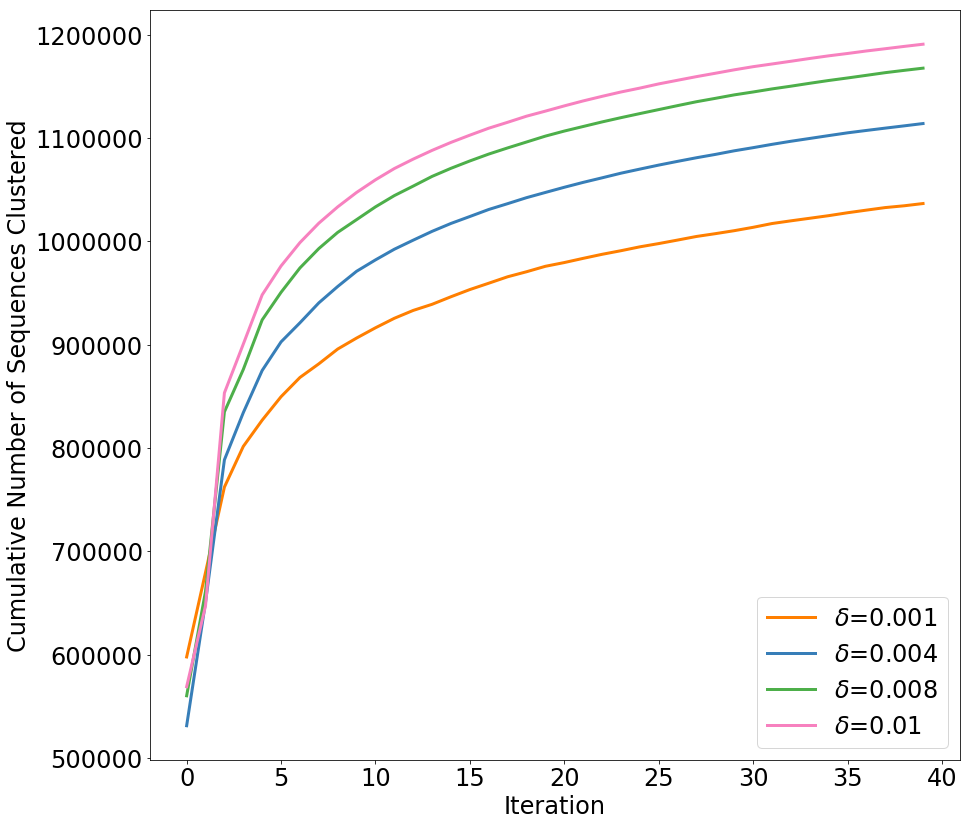

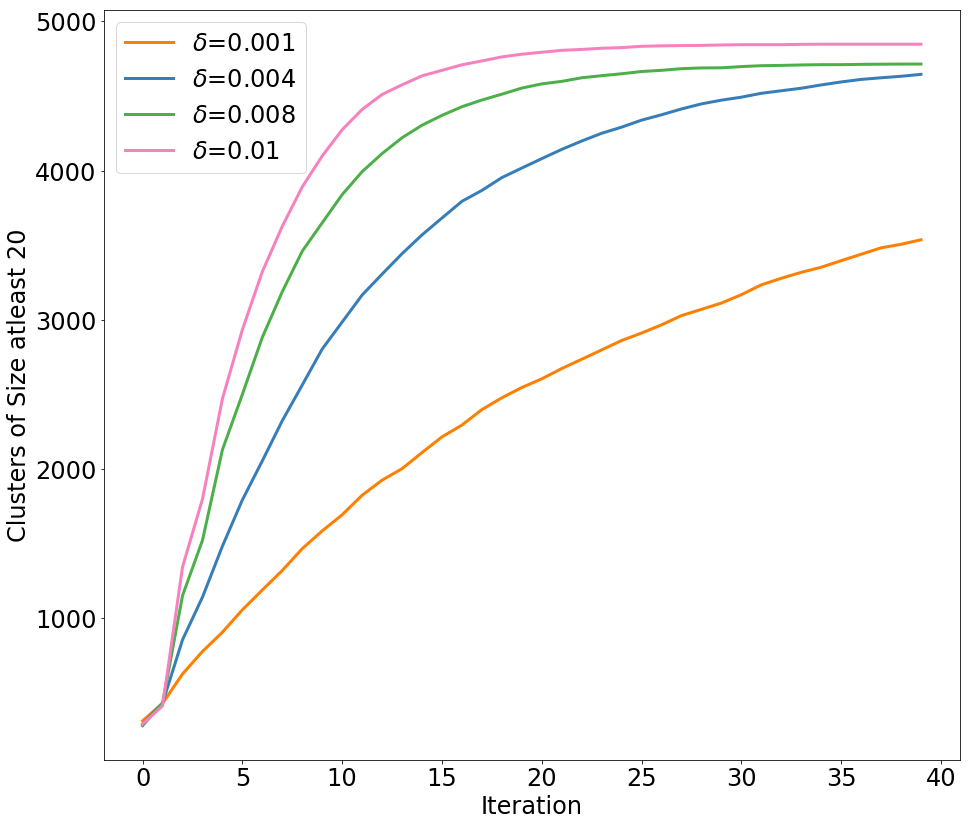

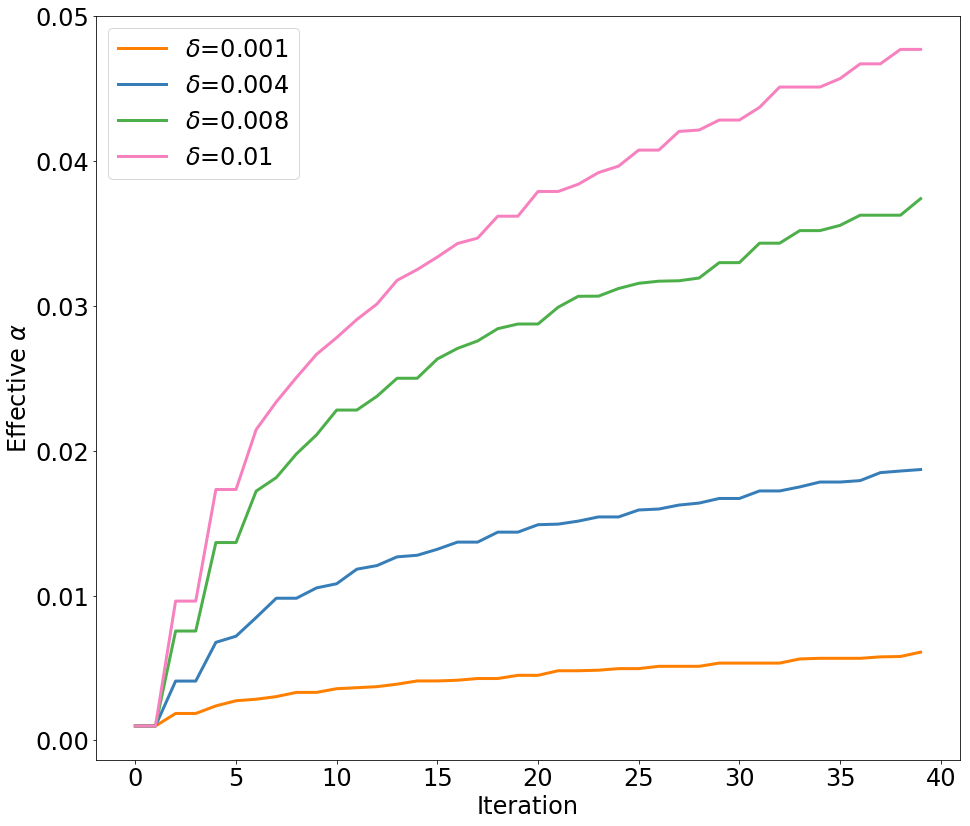

In [15]:
fig, ax = plt.subplots(1,1,figsize = (14,12))
df_delta_alpha_01_summary.loc[0.001].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\delta$'+'=0.001', 
                                     color = colors[0], linewidth = 3)
df_delta_alpha_01_summary.loc[0.004].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\delta$'+'=0.004', 
                                     color = colors[1], linewidth = 3)
df_delta_alpha_01_summary.loc[0.008].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\delta$'+'=0.008', 
                                   color = colors[2], linewidth = 3)
df_delta_alpha_01_summary.loc[0.01].plot('Iteration', 'Cumulative_Clustered', ax = ax, label = r'$\delta$'+'=0.01', 
                                   color = colors[3], linewidth = 3)
ax.set_xlabel('Iteration')
ax.set_ylabel('Cumulative Number of Sequences Clustered')
ax.legend(loc = 4)
fig.tight_layout()
fig.savefig(Plots_Dir+'Delta_CumSum.pdf')

fig, ax = plt.subplots(1,1,figsize = (14,12))
df_delta_alpha_01_summary.loc[0.001].plot('Iteration', 'Cluster_Counts', ax = ax, label = r'$\delta$'+'=0.001', 
                                     color = colors[0], linewidth = 3)
df_delta_alpha_01_summary.loc[0.004].plot('Iteration', 'Cluster_Counts', ax = ax, label = r'$\delta$'+'=0.004', 
                                     color = colors[1], linewidth = 3)
df_delta_alpha_01_summary.loc[0.008].plot('Iteration', 'Cluster_Counts', ax = ax, label = r'$\delta$'+'=0.008', 
                                   color = colors[2], linewidth = 3)
df_delta_alpha_01_summary.loc[0.01].plot('Iteration', 'Cluster_Counts', ax = ax, label = r'$\delta$'+'=0.01', 
                                   color = colors[3], linewidth = 3)
ax.set_xlabel('Iteration')
ax.set_ylabel('Clusters of Size atleast 20')
ax.legend()
fig.tight_layout()
fig.savefig(Plots_Dir+'Delta_Cluster_Counts.pdf')

fig, ax = plt.subplots(1,1,figsize = (14,12))
df_delta_alpha_01_summary.loc[0.001].plot('Iteration', 'Sampling_Rate', ax = ax, label = r'$\delta$'+'=0.001', 
                                     color = colors[0], linewidth = 3)
df_delta_alpha_01_summary.loc[0.004].plot('Iteration', 'Sampling_Rate', ax = ax, label = r'$\delta$'+'=0.004', 
                                     color = colors[1], linewidth = 3)
df_delta_alpha_01_summary.loc[0.008].plot('Iteration', 'Sampling_Rate', ax = ax, label = r'$\delta$'+'=0.008', 
                                   color = colors[2], linewidth = 3)
df_delta_alpha_01_summary.loc[0.01].plot('Iteration', 'Sampling_Rate', ax = ax, label = r'$\delta$'+'=0.01', 
                                   color = colors[3], linewidth = 3)
ax.set_xlabel('Iteration')
ax.set_ylabel('Effective '+r'$\alpha$')
ax.legend(ncol = 1)
fig.tight_layout()
fig.savefig(Plots_Dir+'Varying_Alpha.pdf')


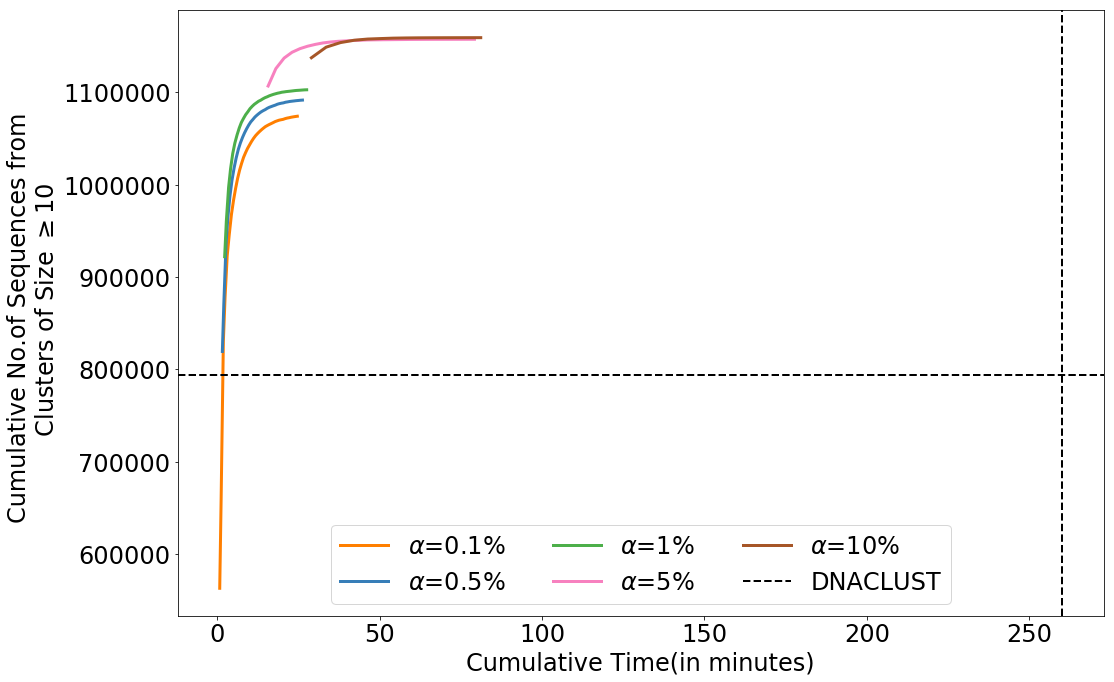

In [12]:
df_ms_adap_cc_01 = pd.read_csv(expt_dir + 'With_Modeshifting/Adaptive/alpha_0.1/Cluster_Summary.txt',sep = '\t', 
                              index_col = 'Iteration')
df_ms_adap_cc_01 = df_ms_adap_cc_01[df_ms_adap_cc_01['Size']>10].groupby('Iteration').sum()
temp = df_ms_adaptive_summary.loc[0.1]
temp = temp.set_index('Iteration')
df_ms_adap_cc_01 = df_ms_adap_cc_01.join(temp)
df_ms_adap_cc_01 = df_ms_adap_cc_01[['Size', 'Full iteration']].reset_index().cumsum()

df_ms_adap_cc_05 = pd.read_csv(expt_dir + 'With_Modeshifting/Adaptive/alpha_0.5/Cluster_Summary.txt',sep = '\t', 
                               index_col = 'Iteration')
df_ms_adap_cc_05 = df_ms_adap_cc_05[df_ms_adap_cc_05['Size']>10].groupby('Iteration').sum()
temp = df_ms_adaptive_summary.loc[0.5]
temp = temp.set_index('Iteration')
df_ms_adap_cc_05 = df_ms_adap_cc_05.join(temp)
df_ms_adap_cc_05 = df_ms_adap_cc_05[['Size', 'Full iteration']].reset_index().cumsum()


df_ms_adap_cc_1 = pd.read_csv(expt_dir + 'With_Modeshifting/Adaptive/alpha_1.0/Cluster_Summary.txt',sep = '\t', 
                             index_col = 'Iteration')
df_ms_adap_cc_1 = df_ms_adap_cc_1[df_ms_adap_cc_1['Size']>10].groupby('Iteration').sum()
temp = df_ms_adaptive_summary.loc[1.0]
temp = temp.set_index('Iteration')
df_ms_adap_cc_1 = df_ms_adap_cc_1.join(temp)
df_ms_adap_cc_1 = df_ms_adap_cc_1[['Size', 'Full iteration']].reset_index().cumsum()

df_ms_adap_cc_5 = pd.read_csv(expt_dir + 'With_Modeshifting/Adaptive/alpha_5.0/Cluster_Summary.txt',sep = '\t', 
                          index_col = 'Iteration')
df_ms_adap_cc_5 = df_ms_adap_cc_5[df_ms_adap_cc_5['Size']>10].groupby('Iteration').sum()
temp = df_ms_adaptive_summary.loc[5.0]
temp = temp.set_index('Iteration')
df_ms_adap_cc_5 = df_ms_adap_cc_5.join(temp)
df_ms_adap_cc_5 = df_ms_adap_cc_5[['Size', 'Full iteration']].cumsum()

df_ms_adap_cc_10 = pd.read_csv(expt_dir + 'With_Modeshifting/Adaptive/alpha_10.0/Cluster_Summary.txt',sep = '\t', 
                           index_col = 'Iteration')
df_ms_adap_cc_10 = df_ms_adap_cc_10[df_ms_adap_cc_10['Size']>10].groupby('Iteration').sum()
temp = df_ms_adaptive_summary.loc[10]
temp = temp.set_index('Iteration')
df_ms_adap_cc_10 = df_ms_adap_cc_10.join(temp)
df_ms_adap_cc_10 = df_ms_adap_cc_10[['Size', 'Full iteration']].cumsum()


plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,1,figsize = (16,10))
df_ms_adap_cc_01.plot('Full iteration','Size', ax = ax, label = r'$\alpha$='+'0.1%', 
                                     color = colors[0], linewidth = 3)
df_ms_adap_cc_05.plot( 'Full iteration','Size', ax = ax, label = r'$\alpha$='+'0.5%', 
                                     color = colors[1], linewidth = 3)
df_ms_adap_cc_1.plot( 'Full iteration','Size', ax = ax, label = r'$\alpha$='+'1%', 
                                   color = colors[2], linewidth = 3)
df_ms_adap_cc_5.plot( 'Full iteration', 'Size',ax = ax, label = r'$\alpha$='+'5%', 
                                   color = colors[3], linewidth = 3)
df_ms_adap_cc_10.plot( 'Full iteration','Size', ax = ax, label = r'$\alpha$='+'10%', 
                                    color = colors[4], linewidth = 3)

ax.axhline(793555, linestyle = '--', color = 'black', label = 'DNACLUST', linewidth=2)
ax.axvline(260, linestyle = '--', color = 'black', linewidth=2)
ax.legend(ncol = 3)
ax.set_ylabel('Cumulative No.of Sequences from \n'+r' Clusters of Size $\geq 10$')
ax.set_xlabel('Cumulative Time(in minutes)')
fig.tight_layout()

#ax.set_ylim([120000, 1350000])
fig.savefig(Plots_Dir+'Comparing Time(SCRAPT).pdf')

In [14]:
df_ms_adaptive_summary.to_csv('Time_MS_SCRAPT.txt')

In [18]:
0.02*(1773543-1002238)

15426.1

In [20]:
0.1/100

0.001